## Challenge: evaluate your sentiment classifier
It's time to revisit your classifier from the previous assignment. Using the evaluation techniques we've covered here, look at your classifier's performance in more detail. Then go back and iterate by engineering new features, removing poor features, or tuning parameters. Repeat this process until you have five different versions of your classifier. Once you've iterated, answer these questions to compare the performance of each:

1) Do any of your classifiers seem to overfit? 
   - The second model appears to overfit the most with a (+-) of 0.07 variance in the cross validation portion. For the most part, overfitting doesn't seem to be a huge issue in these models. In hindsight, dealing with words that occur in different ways would allow for more accuracy, less overfitting, and fewer features in the model. One example is "minutes" and "min". That being said, I noticed that some of the words occurred in both positive and negative comments. That's why I ultimately treated overlapping words like stopwords and elected to remove them to decrease the noise. Another option would be to include phrases instead of single words, but that was a huge undertaking for learning curve and the final model seems to do a decent job at predicting outcome... at least for an initial phase of analysis.

2) Which seem to perform the best? Why?
   - The 5th model performs the best. This is likely due to the fact that more features were determined statistically rather than intuitively. Personal bias was likely an issue in earlier versions. One negative side effect of my feature selection was that there were more words included than I'd like to see in a typical model. In the future, I'd like to learn more effective methods to gain accuracy, while decreasing features.

3) Which features seemed to be most impactful to performance?
   - Words like "great", "delicious", "bad", "minutes", "perfect", and "1" seemed to have the highest impact to performance. There were attempts at associating word counts to classification but didn't appear to improve results, so it was discarded.

4) Write up your iterations and answers to the above questions in a few pages. 

Submit a link below and go over it with your mentor to see if they have any other ideas on how you could improve your classifier's performance.

In [147]:
# import packages

# array-processing 
import numpy as np
# dataframe processing
import pandas as pd

# math/science computing
from scipy.stats import zscore
import scipy.stats as stats

# count stuff
from collections import Counter

# enable classification modeling
# SKLearn requires us to specify an outcome (y/dependant variable) and 
# inputs (x/independent variables)
import sklearn
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB
# enable ability to setup test/training model conditions
from sklearn.model_selection import train_test_split
# evaluate accuracy of classification model
from sklearn.metrics import confusion_matrix
# evaluate model score and overfitting using cross validation methods 
from sklearn.model_selection import cross_val_score

# PCA packages
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# enable inline plotting
%matplotlib inline
# import plotting packages
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

# Shutup Warnings!
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
# import text file and assigning separator based on raw file
df_yelp = pd.read_csv('yelp_labelled.txt', sep='\t', header=None )
df_yelp.columns = ["customer_comments", "customer_rank"] # assigning column names
df_yelp.head()

,customer_comments,customer_rank
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


### Explore and clean up

In [3]:
# View all rows
pd.set_option('display.max_rows', None)

# View all columns
pd.set_option('display.max_columns', None)

# Disable scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [4]:
# create new dataframe to preserve original
df_yelp_cleanup = df_yelp.copy()

In [5]:
# general clean up script that was used in previous exercise. Formats strings to be similar style
spec_chars = ['__', ',', '(', ')', '/', '.', '"', '-','_', '  ' ]

# replace special characters with spaces in customer comments column
# fewer required characters with for loop vs method chaining
for char in spec_chars:
    df_yelp_cleanup['customer_comments'] = df_yelp_cleanup['customer_comments'].str.strip().str.replace(char, ' ')

In [6]:
# checking nulls
df_yelp_cleanup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
customer_comments    1000 non-null object
customer_rank        1000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.7+ KB


In [7]:
# creating new boolean column of True/False.... we have a column of 1 and 0, but the example shows to do this in general cases.
df_yelp_cleanup['positive'] = (df_yelp_cleanup['customer_rank'] == 1)

# Note that if you run this cell a second time everything will become false.
# So... Don't.

df_yelp_cleanup.head()

,customer_comments,customer_rank,positive
0,Wow Loved this place,1,True
1,Crust is not good,0,False
2,Not tasty and the texture was just nasty,0,False
3,Stopped by during the late May bank holiday of...,1,True
4,The selection on the menu was great and so wer...,1,True


In [8]:
# confirming how many positive reviews there are
df_yelp_pos = df_yelp_cleanup[['customer_comments','customer_rank']].filter(df_yelp['customer_rank'] == 1)
df_yelp_pos = df_yelp_cleanup[df_yelp.customer_rank !=0][['customer_comments','customer_rank']]
df_yelp_neg = df_yelp_cleanup[df_yelp.customer_rank !=1][['customer_comments','customer_rank']]


print(df_yelp_pos.shape)
print(df_yelp_neg.shape)

(500, 2)
(500, 2)


In [9]:
# finding words with all caps and creating new column if true
df_yelp_cleanup['allcaps'] = df_yelp_cleanup.customer_comments.str.isupper()

In [10]:
# this must be run AFTER the all caps cell. This is done to normalize text formats to account for all versions of the same words.
df_yelp_cleanup['customer_comments_lwr_case'] = df_yelp_cleanup['customer_comments'].str.lower()

In [11]:
# looking at frequency of words in the column to see if anything stands out
df_yelp_cleanup.customer_comments_lwr_case.str.split(expand=True).stack().value_counts()

the                           585
and                           393
i                             305
was                           294
a                             237
to                            220
is                            171
this                          142
it                            129
of                            127
food                          124
not                           116
in                            109
for                           109
place                         103
good                           91
service                        82
we                             79
very                           76
my                             73
with                           72
great                          68
had                            68
be                             67
that                           67
so                             66
are                            63
were                           62
but                            62
have          

In [12]:
# Counting words in customer_comments_lwr_case
df_yelp_cleanup['word_count'] = df_yelp_cleanup['customer_comments_lwr_case'].str.split(" ").str.len()

In [13]:
df_yelp_cleanup.groupby('customer_rank')['word_count'].value_counts()

customer_rank  word_count
0              4             43
               8             34
               7             33
               10            33
               11            29
               6             28
               9             27
               3             26
               12            26
               5             25
               16            21
               17            21
               15            20
               18            18
               23            18
               13            15
               2             10
               14            10
               19            10
               21            10
               20             8
               24             7
               25             6
               22             5
               28             5
               27             4
               29             3
               26             2
               30             2
               32             1
1             

In [14]:
# create new data frame
df_yelp_2 = df_yelp_cleanup.copy()

In [15]:
# create anticipated "positive" word list
positive_words = ['best', 'great', 'good', 'amazing', 'nice', 'friendly', 'delicious', 'awesome','loved','love']

# create a boolean column for each word in the dataframe 
for key in positive_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    df_yelp_2[str(key)] = df_yelp_2.customer_comments.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

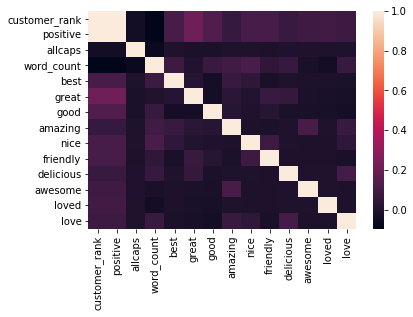

In [16]:
# correlation plot
sns.heatmap(df_yelp_2.corr())

The good news is that not many of the words seem super correlated based on the heatmap.

In [17]:
# define training data and target variables

data = df_yelp_2[positive_words + ['allcaps']] # independent/inputs
target = df_yelp_2['positive'] # dependenty/outcome

In [18]:
# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 360


In [19]:
# Calculate the accuracy of your model here.

total = data.shape[0]
missed = (target != y_pred).sum()
correct = total - missed
accuracy = round(((correct / total) * 100),2)
print('Accuracy of model is :' + str(accuracy) + '%')

Accuracy of model is :64.0%


In [20]:
# evaluate accuracy of classification model
# how well can the model predict a positive/negative review?
confusion_matrix(target, y_pred)

array([[475,  25],
       [335, 165]], dtype=int64)

In [21]:
# Build your confusion matrix and calculate sensitivity and specificity here.

def manual_confusion_matrix(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
           FP += 1
        if y_actual[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
           FN += 1    
    
    sensitivity = round((TP / (TP + FN)) * 100)
    specificity = round((TN / (FP + TN)) * 100)
    print('Sensitivity: ' + str(sensitivity) + '%')
    print('Specificity: ' + str(specificity) + '%')
    return('Confusion Matrix: {}'.format([TP, FP, TN, FN]))
    
manual_confusion_matrix(target, y_pred)

Sensitivity: 33%
Specificity: 95%


'Confusion Matrix: [165, 25, 475, 335]'

In [22]:
# another example I found that does not use sklearn.
# both methods get the same answer, but this one takes guess work out of interpretation.

df_confusion = pd.crosstab(target, y_pred, rownames = ['Actual'], colnames = ['Predicted'])
df_confusion

Predicted,False,True
Actual,,
False,475,25
True,335,165


In [23]:
# Test your model with different holdout groups.

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

With 20% Holdout: 0.665
Testing on Sample: 0.64


In [24]:
# evaluate potential of overfitting.
scores = cross_val_score(bnb, data, target, cv=10)

In [25]:
# mean score
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.64 (+/- 0.04)


Seems like the data is not over-fitting here, but doesn't have a very strong performance.

# Version 2 - Improve positive words/ introduce word counts

In [26]:
# Start new version, beginning with initial clean df
df_v2 = df_yelp_cleanup.copy()

In [27]:
# Counting words in customer_comments
df_v2['word_count'] = df_v2['customer_comments'].str.split(" ").str.len()

In [28]:
# are there any trends with comment length and customer rank?
df_v2.groupby('customer_rank')['word_count'].value_counts()

customer_rank  word_count
0              4             43
               8             34
               7             33
               10            33
               11            29
               6             28
               9             27
               3             26
               12            26
               5             25
               16            21
               17            21
               15            20
               18            18
               23            18
               13            15
               2             10
               14            10
               19            10
               21            10
               20             8
               24             7
               25             6
               22             5
               28             5
               27             4
               29             3
               26             2
               30             2
               32             1
1             

In [29]:
# add boolean column for comments greater than 10 words
df_v2.loc[df_v2['word_count'] >= 10, 'gtr_10_words'] = True
df_v2.loc[df_v2['word_count'] < 10, 'gtr_10_words'] = False

In [30]:
df_v2.head()

,customer_comments,customer_rank,positive,allcaps,customer_comments_lwr_case,word_count,gtr_10_words
0,Wow Loved this place,1,True,False,wow loved this place,5,False
1,Crust is not good,0,False,False,crust is not good,4,False
2,Not tasty and the texture was just nasty,0,False,False,not tasty and the texture was just nasty,8,False
3,Stopped by during the late May bank holiday of...,1,True,False,stopped by during the late may bank holiday of...,15,True
4,The selection on the menu was great and so wer...,1,True,False,the selection on the menu was great and so wer...,12,True


In [31]:
# count frequency of long comments, grouped on customer_rank
df_v2.gtr_10_words.value_counts()

True     521
False    479
Name: gtr_10_words, dtype: int64

In [32]:
# adding more positive words
positive_words = ['best', 'great', 'good', 'amazing', 'nice', 'friendly', 'delicious', 'awesome','loved','love', 'very', 'really', 'more', 'fresh', 'quality', 'better', 'flavor', 'excellent', 'fantastic', 'impressed', 'delicious!', 'attentive', 'ambiance', 'wonderful', 'authentic', 'reasonable', 'fast', '10']
 
# create a boolean column for each word in the dataframe
for key in positive_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    df_v2[str(key)] = df_v2.customer_comments.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

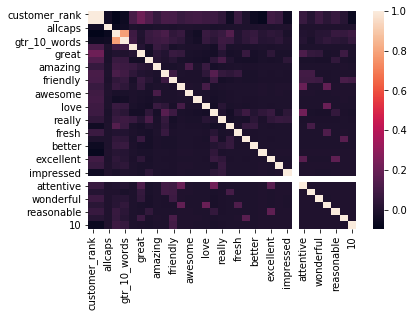

In [33]:
sns.heatmap(df_v2.corr())

The good news is that not many of the words seem super correlated based on the heatmap.

In [34]:
# define training data and target variables

data_2 = df_v2[positive_words + ['allcaps'] ] # independent/inputs
target_2 = df_v2['customer_rank'] # dependenty/outcome

In [35]:
# Instantiate our model and store it in a new variable.
bnb_2 = BernoulliNB()

# Fit our model to the data.
bnb_2.fit(data_2, target_2)

# Classify, storing the result in a new variable.
y_pred_2 = bnb_2.predict(data_2)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data_2.shape[0],
    (target_2 != y_pred_2).sum()
))

Number of mislabeled points out of a total 1000 points : 334


In [36]:
# Calculate the accuracy of your model here.
# prior example: Number of mislabeled points out of 1000: 360
total = data_2.shape[0]
missed = (target_2 != y_pred_2).sum()
correct = total - missed
accuracy = round(((correct / total) * 100),2)
print('Accuracy of model is :' + str(accuracy) + '%')

Accuracy of model is :66.6%


In [37]:
# confusion matrix that does not use sklearn.

df_confusion_2 = pd.crosstab(target_2, y_pred_2, rownames = ['Actual'], colnames = ['Predicted'])
df_confusion_2

Predicted,0,1
Actual,,
0,446,54
1,280,220


In [38]:
# Build your confusion matrix and calculate sensitivity and specificity here.

def manual_confusion_matrix(y_actual_2, y_pred_2):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for i in range(len(y_pred_2)): 
        if y_actual_2[i]==y_pred_2[i]==1:
           TP += 1
        if y_pred_2[i]==1 and y_actual_2[i]!=y_pred_2[i]:
           FP += 1
        if y_actual_2[i]==y_pred_2[i]==0:
           TN += 1
        if y_pred_2[i]==0 and y_actual_2[i]!=y_pred_2[i]:
           FN += 1    
    
    sensitivity = round((TP / (TP + FN)) * 100)
    specificity = round((TN / (FP + TN)) * 100)
    print('Sensitivity: ' + str(sensitivity) + '%')
    print('Specificity: ' + str(specificity) + '%')
    return('Confusion Matrix: {}'.format([TP, FP, TN, FN]))
    
manual_confusion_matrix(target_2, y_pred_2)

Sensitivity: 44%
Specificity: 89%


'Confusion Matrix: [220, 54, 446, 280]'

In [39]:
# Test your model with different holdout groups.

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data_2, target_2, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data_2, target_2).score(data_2, target_2)))

With 20% Holdout: 0.675
Testing on Sample: 0.666


In [40]:
#cross validation scores
scores_2 = cross_val_score(bnb, data_2, target_2, cv=10)
print(scores_2)

[0.63 0.66 0.69 0.7  0.64 0.61 0.69 0.69 0.61 0.64]


In [41]:
# mean score
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_2.mean(), scores_2.std() * 2))

Accuracy: 0.66 (+/- 0.07)


As you can see, the cross validation score doesn't suggest outliers even after adding in all of those new positive words. As far as performance is concerned, however, sensitivity showed an improvement but at the cost of decreasing the specificity.

# Version 3 - Improve positive words another way

It's apparant that the model still struggles by using anectdotal words as a guide for positive reviews. Let's break this down and see if we can't determine which words should be used by cross-referencing the word list and reviewer sentiment. 

In [42]:
# create new dataframe from cleanedup version
df_v3 = df_yelp_cleanup.copy()

In [43]:
df_v3.head()

,customer_comments,customer_rank,positive,allcaps,customer_comments_lwr_case,word_count
0,Wow Loved this place,1,True,False,wow loved this place,5
1,Crust is not good,0,False,False,crust is not good,4
2,Not tasty and the texture was just nasty,0,False,False,not tasty and the texture was just nasty,8
3,Stopped by during the late May bank holiday of...,1,True,False,stopped by during the late may bank holiday of...,15
4,The selection on the menu was great and so wer...,1,True,False,the selection on the menu was great and so wer...,12


In [44]:
# count words in customer_comments_lwr_case column
df_v3['word_count'] = df_v3['customer_comments_lwr_case'].str.split(" ").str.len()

I want to see how many positive words actually lined up with positive reviews from Version 2

In [45]:
# Old list of positive words
old_positive_words = ['best', 'great', 'good', 'amazing', 'nice', 'friendly', 'delicious', 'awesome','loved','love', 'very', 'really', 'more', 'fresh', 'quality', 'better', 'flavor', 'excellent', 'fantastic', 'impressed', 'delicious!', 'attentive', 'ambiance', 'wonderful', 'authentic', 'reasonable', 'fast', '10']
 

In [46]:
# parses words so they can be used in a new column by with conditions applied
pattern = '|'.join(old_positive_words)

In [47]:
pattern

'best|great|good|amazing|nice|friendly|delicious|awesome|loved|love|very|really|more|fresh|quality|better|flavor|excellent|fantastic|impressed|delicious!|attentive|ambiance|wonderful|authentic|reasonable|fast|10'

In [48]:
# create test dataframe 
df_v3_test = df_v3.copy()

In [49]:
# creating new column to see if positive words lined up with positive ranks
df_v3_test['confirm_pos'] = np.where((df_v3_test['customer_comments_lwr_case'].str.contains(pattern)) | (df_v3_test.customer_rank == 1), True, False)

In [50]:
df_v3_test.sort_values('confirm_pos')

,customer_comments,customer_rank,positive,allcaps,customer_comments_lwr_case,word_count,confirm_pos
999,Then as if I hadn't wasted enough of my life t...,0,False,False,then as if i hadn't wasted enough of my life t...,28,False
279,I had the mac salad and it was pretty bland so...,0,False,False,i had the mac salad and it was pretty bland so...,18,False
278,I think not again,0,False,False,i think not again,4,False
655,The fried rice was dry as well,0,False,False,the fried rice was dry as well,7,False
807,Not a single employee came out to see if we we...,0,False,False,not a single employee came out to see if we we...,25,False
811,The service was terrible though,0,False,False,the service was terrible though,5,False
813,It was packed!!,0,False,False,it was packed!!,3,False
269,For a self proclaimed coffee cafe I was wildly...,0,False,False,for a self proclaimed coffee cafe i was wildly...,10,False
516,it was a drive to get there,0,False,False,it was a drive to get there,7,False
266,The service was not up to par either,0,False,False,the service was not up to par either,8,False


In [51]:
df_v3_test.confirm_pos.value_counts()

True     635
False    365
Name: confirm_pos, dtype: int64

It appears some words that were initially chosen to represent positive reviews are used quite frequently in negative reviews. This could explain the failing models. Let's remove some of these words and rerun the model. Also, there seems to be more falsly represented rows due to the original word selection.

In [52]:
positive_words = ['best', 'great', 'good', 'amazing', 'nice', 'friendly', 'delicious', 'awesome','loved','love']
 
# create a boolean column for each word in the dataframe     
for key in positive_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    df_v3[str(key)] = df_v3.customer_comments_lwr_case.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

In [53]:
# add boolean column for comments greater than 10 words
df_v3.loc[df_v3['word_count'] >= 10, 'gtr_10_words'] = True
df_v3.loc[df_v3['word_count'] < 10, 'gtr_10_words'] = False

In [54]:
df_v3.head()

,customer_comments,customer_rank,positive,allcaps,customer_comments_lwr_case,word_count,best,great,good,amazing,nice,friendly,delicious,awesome,loved,love,gtr_10_words
0,Wow Loved this place,1,True,False,wow loved this place,5,False,False,False,False,False,False,False,False,True,False,False
1,Crust is not good,0,False,False,crust is not good,4,False,False,False,False,False,False,False,False,False,False,False
2,Not tasty and the texture was just nasty,0,False,False,not tasty and the texture was just nasty,8,False,False,False,False,False,False,False,False,False,False,False
3,Stopped by during the late May bank holiday of...,1,True,False,stopped by during the late may bank holiday of...,15,False,False,False,False,False,False,False,False,True,False,True
4,The selection on the menu was great and so wer...,1,True,False,the selection on the menu was great and so wer...,12,False,True,False,False,False,False,False,False,False,False,True


In [55]:
df_v3.gtr_10_words.value_counts()

True     521
False    479
Name: gtr_10_words, dtype: int64

Let's check how our new list performs.

In [56]:
pattern = '|'.join(positive_words)

In [57]:
pattern

'best|great|good|amazing|nice|friendly|delicious|awesome|loved|love'

In [58]:
df_v3['confirm_pos'] = np.where((df_v3['customer_comments_lwr_case'].str.contains(pattern)) | (df_v3.customer_rank == 1), True, False)

In [59]:
df_v3.sort_values('confirm_pos')

,customer_comments,customer_rank,positive,allcaps,customer_comments_lwr_case,word_count,best,great,good,amazing,nice,friendly,delicious,awesome,loved,love,gtr_10_words,confirm_pos
999,Then as if I hadn't wasted enough of my life t...,0,False,False,then as if i hadn't wasted enough of my life t...,28,False,False,False,False,False,False,False,False,False,False,True,False
777,So in a nutshell: 1 The restaraunt smells like...,0,False,False,so in a nutshell: 1 the restaraunt smells like...,19,False,False,False,False,False,False,False,False,False,False,True,False
778,My girlfriend's veal was very bad,0,False,False,my girlfriend's veal was very bad,6,False,False,False,False,False,False,False,False,False,False,False,False
371,They dropped more than the ball,0,False,False,they dropped more than the ball,6,False,False,False,False,False,False,False,False,False,False,False,False
370,I left with a stomach ache and felt sick the r...,0,False,False,i left with a stomach ache and felt sick the r...,14,False,False,False,False,False,False,False,False,False,False,True,False
366,My wife had the Lobster Bisque soup which was ...,0,False,False,my wife had the lobster bisque soup which was ...,10,False,False,False,False,False,False,False,False,False,False,True,False
365,I find wasting food to be despicable but this ...,0,False,False,i find wasting food to be despicable but this ...,12,False,False,False,False,False,False,False,False,False,False,True,False
784,The chains which I'm no fan of beat this place...,0,False,False,the chains which i'm no fan of beat this place...,11,False,False,False,False,False,False,False,False,False,False,True,False
363,Definitely a turn off for me & i doubt I'll be...,0,False,False,definitely a turn off for me & i doubt i'll be...,17,False,False,False,False,False,False,False,False,False,False,True,False
786,We will not be coming back,0,False,False,we will not be coming back,6,False,False,False,False,False,False,False,False,False,False,False,False


In [60]:
df_v3.confirm_pos.value_counts()

True     543
False    457
Name: confirm_pos, dtype: int64

In [61]:
# doesn't seem important to keep using the allcaps variable, especially since some are associated with negative reviews.
df_v3.allcaps.value_counts()

False    995
True       5
Name: allcaps, dtype: int64

It's clear that not many words with all caps exist in the data set. Don't need to use this going forward.

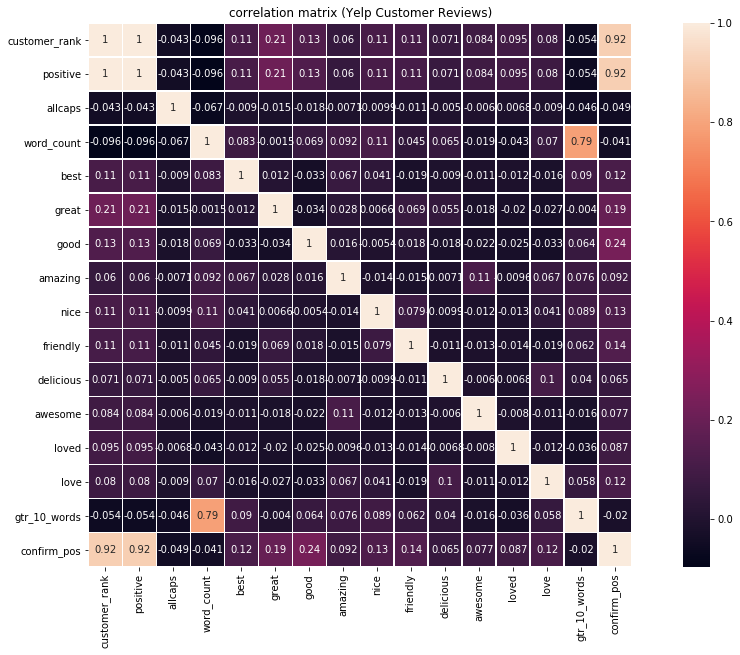

In [62]:
#sns.heatmap(df_v3.corr())
# plot correlation matrix visual
corrmat_life = df_v3.corr()

plt.figure(figsize= (40,10))

plt.subplot(1,2,1)
# draw the heatmap using seaborn.
sns.heatmap(corrmat_life, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (Yelp Customer Reviews)")

plt.show()

The good news is that not many of the words seem super correlated based on the heatmap. The bad news is the columns "gtr_10_words", "positive", and "confirm_pos" seem redundant. Keeping "word_count" because it appears slightly more correlated than "gtr_10_words" variable. Let's drop some columns.

In [63]:
df_v3 = df_v3.drop(columns=['confirm_pos', 'gtr_10_words', 'positive'])

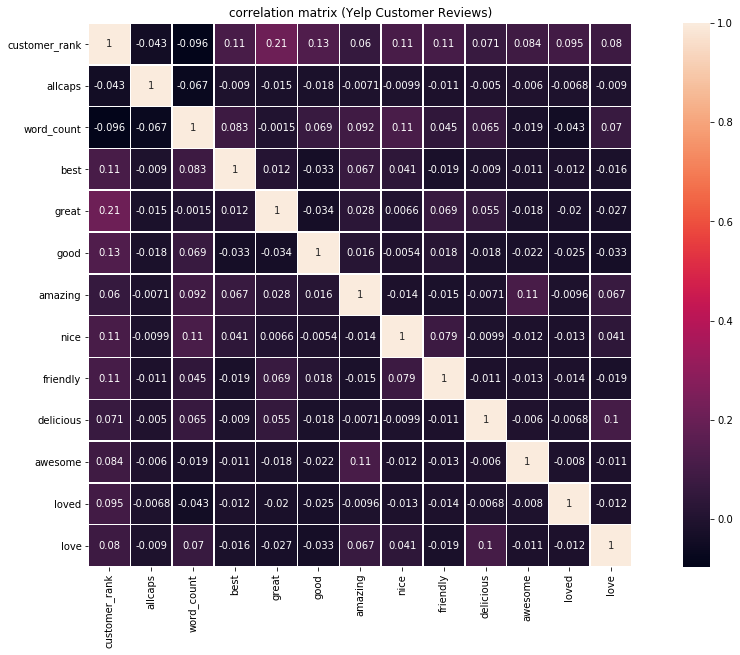

In [64]:
# plot correlation matrix visual
corrmat_life = df_v3.corr()

plt.figure(figsize= (40,10))

plt.subplot(1,2,1)
# draw the heatmap using seaborn.
sns.heatmap(corrmat_life, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (Yelp Customer Reviews)")

plt.show()

In [65]:
# define training data and target variables

data_3 = df_v3[positive_words] # independent/inputs
target_3 = df_v3['customer_rank'] # dependenty/outcome

In [66]:
# Instantiate our model and store it in a new variable.
bnb_3 = BernoulliNB()

# Fit our model to the data.
bnb_3.fit(data_3, target_3)

# Classify, storing the result in a new variable.
y_pred_3 = bnb_3.predict(data_3)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data_3.shape[0],
    (target_3 != y_pred_3).sum()
))

Number of mislabeled points out of a total 1000 points : 360


In [67]:
# Calculate the accuracy of your model here.
# prior example: Number of mislabeled points out of 1000: 360
total = data_3.shape[0]
missed = (target_3 != y_pred_3).sum()
correct = total - missed
accuracy = round(((correct / total) * 100),2)
print('Accuracy of model is :' + str(accuracy) + '%')

Accuracy of model is :64.0%


In [68]:
#confusion matrix that does not use sklearn.

df_confusion_3 = pd.crosstab(target_3, y_pred_3, rownames = ['Actual'], colnames = ['Predicted'])
df_confusion_3

Predicted,0,1
Actual,,
0,475,25
1,335,165


In [69]:
# Build your confusion matrix and calculate sensitivity and specificity here.

def manual_confusion_matrix(y_actual_3, y_pred_3):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for i in range(len(y_pred_3)): 
        if y_actual_3[i]==y_pred_3[i]==1:
           TP += 1
        if y_pred_3[i]==1 and y_actual_3[i]!=y_pred_3[i]:
           FP += 1
        if y_actual_3[i]==y_pred_3[i]==0:
           TN += 1
        if y_pred_3[i]==0 and y_actual_3[i]!=y_pred_3[i]:
           FN += 1    
    
    sensitivity = round((TP / (TP + FN)) * 100)
    specificity = round((TN / (FP + TN)) * 100)
    print('Sensitivity: ' + str(sensitivity) + '%')
    print('Specificity: ' + str(specificity) + '%')
    return('Confusion Matrix: {}'.format([TP, FP, TN, FN]))
    
manual_confusion_matrix(target_3, y_pred_3)

Sensitivity: 33%
Specificity: 95%


'Confusion Matrix: [165, 25, 475, 335]'

In [70]:
# Test your model with different holdout groups.

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data_3, target_3, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data_3, target_3).score(data_3, target_3)))

With 20% Holdout: 0.665
Testing on Sample: 0.64


In [71]:
#cross validation scores
cross_val_score(bnb_3, data_3, target_3, cv=10)

array([0.62, 0.62, 0.64, 0.62, 0.63, 0.63, 0.68, 0.65, 0.63, 0.68])

Seems like we're back at step 1! It appears focusing only on the positive reviews is not helping us. Can't seem to improve performance much.

# Version 4 - Insert negative word list

This time, let's make a list that is also bad words and invert them as a way to demonstrate that negative words do not exist.

In [72]:
# create dataframe from cleaned up version
df_v4 = df_yelp_cleanup.copy()

In [73]:
df_v4.head()

,customer_comments,customer_rank,positive,allcaps,customer_comments_lwr_case,word_count
0,Wow Loved this place,1,True,False,wow loved this place,5
1,Crust is not good,0,False,False,crust is not good,4
2,Not tasty and the texture was just nasty,0,False,False,not tasty and the texture was just nasty,8
3,Stopped by during the late May bank holiday of...,1,True,False,stopped by during the late may bank holiday of...,15
4,The selection on the menu was great and so wer...,1,True,False,the selection on the menu was great and so wer...,12


In [74]:
positive_words = ['best', 'great', 'good', 'cute', 'amazing', 'enjoy', 'nice', 'friendly', 'delicious', 'awesome','loved','love']

# create boolean columns for each word
for key in positive_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    df_v4[str(key)] = df_v4.customer_comments_lwr_case.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

In [75]:
negative_words = ['terrible', 'horrible', 'wasted', 'overpriced', 'worse', 'worst', "don't", 'never', 'stinks', 'disappointed', 'sad', 'zero', 'rather', 'slow', 'wrong', 'bad', 'not', 'bland', "wasn't", 'mediocre', 'lacking', 'mistake']

In [76]:
# create boolean columns for each word
for key in negative_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    df_v4[str(key)] = df_v4.customer_comments_lwr_case.str.contains(
        '' + str(key) + '',
        case=False
    )

In [77]:
df_v4.loc[df_v4['word_count'] >= 10, 'gtr_10_words'] = True
df_v4.loc[df_v4['word_count'] < 10, 'gtr_10_words'] = False

Let's check to see if our selected words line up in the correct class of customer rank.

In [78]:
pattern = '|'.join(positive_words)

In [79]:
pattern

'best|great|good|cute|amazing|enjoy|nice|friendly|delicious|awesome|loved|love'

In [80]:
neg_pattern = '|'.join(negative_words)

In [81]:
neg_pattern

"terrible|horrible|wasted|overpriced|worse|worst|don't|never|stinks|disappointed|sad|zero|rather|slow|wrong|bad|not|bland|wasn't|mediocre|lacking|mistake"

In [82]:
df_v4['confirm_pos'] = np.where((df_v4['customer_comments_lwr_case'].str.contains(pattern)) | (df_v4.customer_rank == 1), True, False)

In [83]:
df_v4['confirm_pos_2'] = np.where((df_v4['customer_comments_lwr_case'].str.contains(pattern)), True, False)

In [84]:
df_v4['confirm_neg'] = np.where((df_v4['customer_comments_lwr_case'].str.contains(neg_pattern)) | (df_v4.customer_rank == 0), True, False)

In [85]:
df_v4['confirm_neg_2'] = np.where((df_v4['customer_comments_lwr_case'].str.contains(neg_pattern)), True, False)

In [86]:
df_v4.groupby('customer_rank')['confirm_pos_2'].value_counts()

customer_rank  confirm_pos_2
0              False            453
               True              47
1              True             266
               False            234
Name: confirm_pos_2, dtype: int64

In [87]:
df_v4.groupby('customer_rank')['confirm_neg_2'].value_counts()

customer_rank  confirm_neg_2
0              True             254
               False            246
1              False            463
               True              37
Name: confirm_neg_2, dtype: int64

In [88]:
# counts negative word frequency by customer rank
for word in negative_words:
    print(df_v4.groupby('customer_rank')[word].value_counts())

customer_rank  terrible
0              False       490
               True         10
1              False       500
Name: terrible, dtype: int64
customer_rank  horrible
0              False       494
               True          6
1              False       500
Name: horrible, dtype: int64
customer_rank  wasted
0              False     499
               True        1
1              False     500
Name: wasted, dtype: int64
customer_rank  overpriced
0              False         494
               True            6
1              False         500
Name: overpriced, dtype: int64
customer_rank  worse
0              False    498
               True       2
1              False    500
Name: worse, dtype: int64
customer_rank  worst
0              False    486
               True      14
1              False    499
               True       1
Name: worst, dtype: int64
customer_rank  don't
0              False    477
               True      23
1              False    497
               True  

In [89]:
# counts positive word frequency by customer rank
for word in positive_words:
    print(df_v4.groupby('customer_rank')[word].value_counts().sort_values())

customer_rank  best 
0              True       1
1              True      15
               False    485
0              False    499
Name: best, dtype: int64
customer_rank  great
1              True      43
               False    457
0              False    500
Name: great, dtype: int64
customer_rank  good 
0              True      15
1              True      47
               False    453
0              False    485
Name: good, dtype: int64
customer_rank  cute 
0              False    500
1              False    500
Name: cute, dtype: int64
customer_rank  amazing
0              True         2
1              True         8
               False      492
0              False      498
Name: amazing, dtype: int64
customer_rank  enjoy
1              True       2
0              True       4
               False    496
1              False    498
Name: enjoy, dtype: int64
customer_rank  nice 
0              True       2
1              True      17
               False    483
0              F

In [90]:
df_v4.confirm_pos.value_counts()

True     547
False    453
Name: confirm_pos, dtype: int64

In [91]:
df_v4.confirm_neg.value_counts()

True     537
False    463
Name: confirm_neg, dtype: int64

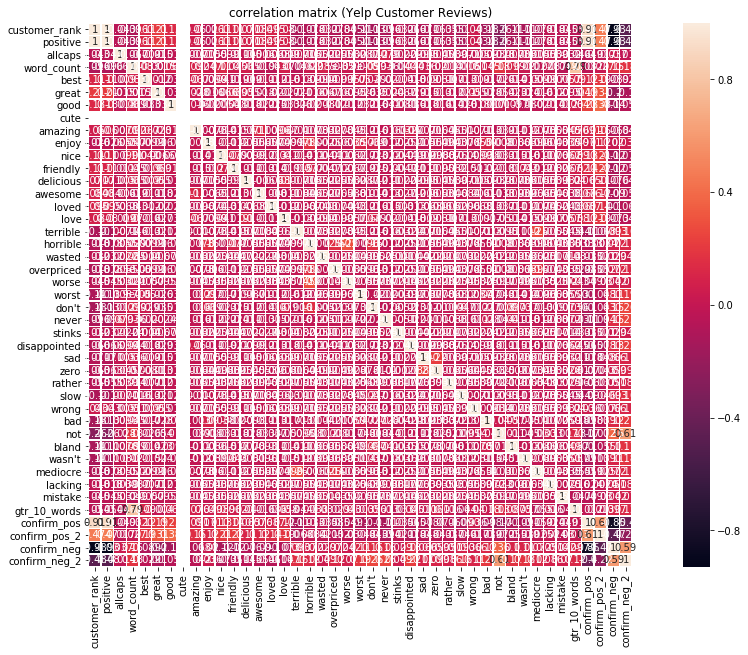

In [92]:
#sns.heatmap(df_v4.corr())
# plot correlation matrix visual
corrmat_life = df_v4.corr()

plt.figure(figsize= (40,10))

plt.subplot(1,2,1)
# draw the heatmap using seaborn.
sns.heatmap(corrmat_life, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (Yelp Customer Reviews)")

plt.show()

In [93]:
words_list = positive_words + negative_words

In [94]:
# define training data and target variables

data_4 = df_v4[words_list] # independent/inputs
target_4 = df_v4['customer_rank'] # dependenty/outcome

In [95]:
# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data_4, target_4)

# Classify, storing the result in a new variable.
y_pred_4 = bnb.predict(data_4)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data_4.shape[0],
    (target_4 != y_pred_4).sum()
))

Number of mislabeled points out of a total 1000 points : 280


In [96]:
# Calculate the accuracy of your model here.
# prior example: Number of mislabeled points out of 1000: 360
total = data_4.shape[0]
missed = (target_4 != y_pred_4).sum()
correct = total - missed
accuracy = round(((correct / total) * 100),2)
print('Accuracy of model is :' + str(accuracy) + '%')

Accuracy of model is :72.0%


In [97]:
# confusion matrix that does not use sklearn.

df_confusion_4 = pd.crosstab(target_4, y_pred_4, rownames = ['Actual'], colnames = ['Predicted'])
df_confusion_4

Predicted,0,1
Actual,,
0,251,249
1,31,469


In [98]:
# Build your confusion matrix and calculate sensitivity and specificity here.

def manual_confusion_matrix(y_actual_4, y_pred_4):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for i in range(len(y_pred_4)): 
        if y_actual_4[i]==y_pred_4[i]==1:
           TP += 1
        if y_pred_4[i]==1 and y_actual_4[i]!=y_pred_4[i]:
           FP += 1
        if y_actual_4[i]==y_pred_4[i]==0:
           TN += 1
        if y_pred_4[i]==0 and y_actual_4[i]!=y_pred_4[i]:
           FN += 1    
    
    sensitivity = round((TP / (TP + FN)) * 100)
    specificity = round((TN / (FP + TN)) * 100)
    print('Sensitivity: ' + str(sensitivity) + '%')
    print('Specificity: ' + str(specificity) + '%')
    return('Confusion Matrix: {}'.format([TP, FP, TN, FN]))
    
manual_confusion_matrix(target_4, y_pred_4)

Sensitivity: 94%
Specificity: 50%


'Confusion Matrix: [469, 249, 251, 31]'

In [99]:
# Test your model with different holdout groups.


# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data_4, target_4, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data_4, target_4).score(data_4, target_4)))

With 20% Holdout: 0.68
Testing on Sample: 0.72


In [100]:
#cross validation scores
scores_4 = cross_val_score(bnb, data_4, target_4, cv=10)
print(scores_4)

[0.72 0.69 0.77 0.72 0.75 0.67 0.74 0.73 0.7  0.67]


In [101]:
# mean score
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_4.mean(), scores_4.std() * 2))

Accuracy: 0.72 (+/- 0.06)


The model is improved again. It seems the accuracy of predicting the negative reviews increased dramatically. 
However, we are still struggling to accurately predict positive reviews. At this point, the model is about as accurate as a coin flip in regards to positive reviews.

# Version 5 - Exclude Stop Words/Cancel out common words

Starting over from scratch to accomplish the goals in this version. <br> Will go through the cleanup process again.

In [102]:
df_v5 = df_yelp.copy()

In [103]:
# general clean up script that was used in previous exercise. Formats strings to be similar style
spec_chars = ['__', ',', '(', ')', '/', '.', '"', '-','_', '  ' ]

# fewer required characters with for loop vs method chaining
for char in spec_chars:
    df_v5['customer_comments'] = df_v5['customer_comments'].str.strip().str.replace(char, ' ')

In [104]:
# this must be run AFTER the all caps cell. This is done to normalize text formats to account for all versions of the same words.
df_v5['customer_comments_lwr_case'] = df_v5['customer_comments'].str.lower()

In [105]:
df_v5.head()

,customer_comments,customer_rank,customer_comments_lwr_case
0,Wow Loved this place,1,wow loved this place
1,Crust is not good,0,crust is not good
2,Not tasty and the texture was just nasty,0,not tasty and the texture was just nasty
3,Stopped by during the late May bank holiday of...,1,stopped by during the late may bank holiday of...
4,The selection on the menu was great and so wer...,1,the selection on the menu was great and so wer...


In [106]:
# general clean up script that was used in previous exercise. Normalizes column names and removes special characters
spec_chars = ['__', ',', '!', '(', ')', '/', '.', '"', '-', ' ', '  ']

# fewer required characters with for loop vs method chaining
for char in spec_chars:
    df_v5.customer_comments_lwr_case = df_v5.customer_comments_lwr_case.str.replace(char, ' ')

# needed to do this str.replace method separate from above because it took 2 runs of the code to work and that's not intuitive for users
#df_v5.customer_comments_lwr_case = df_v5.customer_comments_lwr_case.str.strip().str.lower().str.replace(' ', '_')

In [107]:
# replacing "&" with "and"
spec_chars = ['&']

# fewer required characters with for loop vs method chaining
for char in spec_chars:
    df_v5.customer_comments_lwr_case = df_v5.customer_comments_lwr_case.str.replace(char, 'and')

Something that was not considered in earlier versions was the removal of stop words. These will be removed in this version to remove unnecessary words.

In [108]:
# importing stopwords 
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [109]:
# after reviewing the list of stop words and customer comments, these words were considered important to keep in the mode.
# removing these words from the stopword list will keep them inside the dataframe.
stop = [word for word in stop if word != "don't"]
stop = [word for word in stop if word != "not"]
stop = [word for word in stop if word != "won't"]
stop = [word for word in stop if word != "wouldn't"]

In [110]:
# removes stopwords from dataframe, and creates new column with remaining words.
# the result, in this case, is a series of stings per cell. 
# the other option is leave a list of words in each cell but the typical code in this workflow won't work the same.
df_v5['stop_comments'] = df_v5['customer_comments_lwr_case'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))

In [111]:
# apostrophies remain, so this will remove them in order to normalize text further.
spec_chars = ["'"]

# fewer required characters with for loop vs method chaining
for char in spec_chars:
    df_v5.stop_comments = df_v5.stop_comments.str.replace(char, '')

In [112]:
# Counting words in customer_comments
df_v5['word_count'] =  df_v5['stop_comments'].str.split(" ").str.len()

In [113]:
df_v5.sample(10)

,customer_comments,customer_rank,customer_comments_lwr_case,stop_comments,word_count
182,I dressed up to be treated so rudely!,0,i dressed up to be treated so rudely,dressed treated rudely,3
765,Tasted like dirt,0,tasted like dirt,tasted like dirt,3
339,There is nothing authentic about this place,0,there is nothing authentic about this place,nothing authentic place,3
42,Hard to judge whether these sides were good be...,0,hard to judge whether these sides were good be...,hard judge whether sides good grossed melted s...,13
67,Update went back for a second time and it wa...,1,update went back for a second time and it was...,update went back second time still amazing,7
913,How can you call yourself a steakhouse if you ...,0,how can you call yourself a steakhouse if you ...,call steakhouse cant properly cook steak dont ...,8
195,The best place to go for a tasty bowl of Pho!,1,the best place to go for a tasty bowl of pho,best place go tasty bowl pho,6
78,Today is the second time I've been to their lu...,1,today is the second time i've been to their lu...,today second time ive lunch buffet pretty good,8
866,This place is awesome if you want something li...,1,this place is awesome if you want something li...,place awesome want something light healthy summer,7
73,It took over 30 min to get their milkshake whi...,0,it took over 30 min to get their milkshake whi...,took 30 min get milkshake nothing chocolate milk,8


In [114]:
# looking at frequency of words in the column to see if anything stands out
df_v5.stop_comments.str.split(expand=True).stack().value_counts()

food                 126
not                  116
place                106
good                  95
service               84
great                 70
back                  61
like                  46
go                    44
time                  42
really                36
best                  30
dont                  28
ever                  28
would                 28
friendly              27
also                  27
one                   26
never                 26
nice                  25
restaurant            25
amazing               24
delicious             23
vegas                 22
im                    21
pretty                20
ive                   20
experience            20
came                  20
staff                 19
definitely            19
well                  19
wont                  19
disappointed          19
even                  19
love                  19
get                   19
minutes               19
eat                   19
us                    19


Next, let's see the break down of words used based on customer rank.

In [115]:
# creates new dataframes that contain ONLY positive or negative reviews, respecitvely.
pos_rank = df_v5[df_v5.customer_rank == 1]
neg_rank = df_v5[df_v5.customer_rank == 0]

In [116]:
pos_rank.sort_values(by =['word_count'], ascending = False)

,customer_comments,customer_rank,customer_comments_lwr_case,stop_comments,word_count
715,Only Pros : Large seating area Nice bar area G...,1,only pros : large seating area nice bar area g...,pros : large seating area nice bar area great ...,18
157,I ordered the Voodoo pasta and it was the firs...,1,i ordered the voodoo pasta and it was the firs...,ordered voodoo pasta first time id really exce...,16
132,They have a good selection of food including a...,1,they have a good selection of food including a...,good selection food including massive meatloaf...,15
123,The guys all had steaks and our steak loving s...,1,the guys all had steaks and our steak loving s...,guys steaks steak loving son steak best worst ...,15
100,Our server was fantastic and when he found out...,1,our server was fantastic and when he found out...,server fantastic found wife loves roasted garl...,15
533,If you love authentic Mexican food and want a ...,1,if you love authentic mexican food and want a ...,love authentic mexican food want whole bunch i...,15
189,Also were served hot bread and butter and home...,1,also were served hot bread and butter and home...,also served hot bread butter home made potato ...,14
395,To summarize the food was incredible nay tran...,1,to summarize the food was incredible nay trans...,summarize food incredible nay transcendant not...,14
456,The food was very good and I enjoyed every mou...,1,the food was very good and i enjoyed every mou...,food good enjoyed every mouthful enjoyable rel...,13
588,My breakfast was perpared great with a beautif...,1,my breakfast was perpared great with a beautif...,breakfast perpared great beautiful presentatio...,13


In [117]:
# looking at frequency of words in the column to see if anything stands out
pos_words = pos_rank.stop_comments.str.split(expand=True).stack().value_counts()

In [118]:
# looking at frequency of words in the column to see if anything stands out
neg_words = neg_rank.stop_comments.str.split(expand=True).stack().value_counts()

In [119]:
pos_words_df = pd.DataFrame(pos_words)
pos_words_df.columns = ['pos_word_count']

In [120]:
neg_words_df = pd.DataFrame(neg_words)
neg_words_df.columns = ['neg_word_count']

In [121]:
# removes words that were only used 1 time.
pos_words_list = pos_words_df[pos_words_df['pos_word_count'] >= 2].index

In [122]:
pos_words_list

Index(['good', 'great', 'food', 'place', 'service', 'friendly', 'delicious',
       'back', 'nice', 'best',
       ...
       'summer', 'feeling', 'home', 'marrow', 'priced', 'high', 'treat',
       'stopped', 'greeted', 'bay'],
      dtype='object', length=396)

In [123]:
# removes words that were only used 1 time.
neg_words_list = neg_words_df[neg_words_df['neg_word_count'] >= 2].index

In [124]:
neg_words_list

Index(['not', 'food', 'place', 'service', 'back', 'like', 'go', 'dont',
       'never', 'good',
       ...
       'hair', 'reviews', '35', 'grease', 'review', 'basically', 'front',
       'disrespected', 'wasting', 'lacking'],
      dtype='object', length=458)

I only want to see words that exist in either positive or negative comments.

In [125]:
# removes words from the negative word list if they also exist the positive word list.
new_neg_list = list(set(neg_words_list).difference(set(pos_words_list)))
print(new_neg_list)

['texture', 'dirt', 'meh', 'underwhelming', 'big', 'star', 'valley', 'rated', '3', 'maybe', 'bit', 'rude', 'given', 'seemed', 'sad', 'three', 'walked', 'meals', 'edible', 'elsewhere', 'impressed', 'pay', 'chewy', 'total', 'bug', 'unless', 'review', 'car', 'started', 'grill', 'refill', 'stomach', 'terrible', 'long', 'sucked', 'bother', 'dirty', 'hair', 'gross', 'doubt', 'done', 'wouldnt', 'slow', 'salt', 'find', 'finally', 'disappointment', 'style', 'nothing', 'paid', 'bisque', 'building', 'servers', 'kids', 'worse', 'charcoal', 'excuse', '20', 'crowd', 'suck', 'live', 'attitudes', 'crust', 'fly', 'although', 'lobster', '1', 'restaurants', 'bill', 'watched', 'known', 'treated', 'use', 'course', 'services', 'totally', 'please', 'worst', 'kept', 'favor', 'wife', 'either', 'stale', 'six', 'rice', 'acknowledged', 'break', 'unfortunately', 'water', 'piece', 'vegetables', 'weve', 'talk', 'green', 'let', 'overpriced', 'longer', 'checked', 'eating', 'disappointing', 'yet', 'husband', 'getting',

In [126]:
# removes words from the positive word list if they also exist the negative word list.
new_pos_list = list(set(pos_words_list).difference(set(neg_words_list)))
print(new_pos_list)

['music', 'options', 'beer', 'inside', 'serve', 'spot', 'twice', 'today', 'great', 'steaks', 'brick', 'impeccable', 'summer', 'thin', 'chinese', 'watch', 'disappoint', 'belly', 'stopped', 'mouth', 'stop', 'cooked', 'perfection', 'tots', 'puree', 'hit', 'oven', 'favorite', 'delicious', 'bowl', 'feeling', 'yummy', 'priced', 'quick', 'regular', 'rolls', 'reasonable', 'seasoned', 'comfortable', 'used', 'beautiful', 'soooo', 'wow', 'family', 'recommended', 'tribute', 'years', 'couple', 'seating', 'extra', 'perfectly', 'wrong', 'greek', 'grilled', 'stuff', 'second', 'eggplant', 'pleasant', 'vibe', 'drink', 'vegetarian', 'chef', 'feels', 'cool', 'ladies', 'excellent', 'outstanding', 'boyfriend', 'mmmm', 'fast', 'melt', 'loved', 'creamy', 'ambience', 'house', 'appetizers', 'definately', 'lots', 'portion', 'different', 'amount', 'healthy', 'bread', '5', 'professional', 'cream', 'dressing', 'setting', 'egg', 'duck', 'sweet', 'liked', 'nicest', 'oh', 'desserts', 'week', 'though', 'told', 'subway'

In [127]:
# combining both lists into 1 for a single, comprehensive list of key words
word_list = new_pos_list + new_neg_list

In [128]:
# create boolean columns for each word
for key in word_list:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    df_v5[str(key)] = df_v5.stop_comments.str.contains(
        '' + str(key) + '',
        case=False
    )

In [129]:
df_v5.head()

,customer_comments,customer_rank,customer_comments_lwr_case,stop_comments,word_count,music,options,beer,inside,serve,spot,twice,today,great,steaks,brick,impeccable,summer,thin,chinese,watch,disappoint,belly,stopped,mouth,stop,cooked,perfection,tots,puree,hit,oven,favorite,delicious,bowl,feeling,yummy,priced,quick,regular,rolls,reasonable,seasoned,comfortable,used,beautiful,soooo,wow,family,recommended,tribute,years,couple,seating,extra,perfectly,wrong,greek,grilled,stuff,second,eggplant,pleasant,vibe,drink,vegetarian,chef,feels,cool,ladies,excellent,outstanding,boyfriend,mmmm,fast,melt,loved,creamy,ambience,house,appetizers,definately,lots,portion,different,amount,healthy,bread,5,professional,cream,dressing,setting,egg,duck,sweet,liked,nicest,oh,desserts,week,though,told,subway,decor,stuffed,fun,omg,incredible,selections,salmon,thumbs,huge,quickly,decorated,especially,salsa,recommendation,tacos,8,glad,every,bacon,perfect,patio,touch,marrow,prices,treat,potatoes,enjoyed,pizzas,plus,generous,butter,white,cute,wall,hope,playing,strip,wonderful,several,attentive,:,joint,interesting,atmosphere,sides,pork,highly,legit,italian,bartender,delightful,paper,need,brunch,awesome,simple,moist,town,ice,fact,equally,group,owner,greeted,salads,pita,party,phoenix,world,visit,assure,hummus,cafe,ago,care,die,sticks,crispy,fantastic,top,added,dark,delish,tender,fine,choose,hands,folks,pleased,delight,flavorful,happy,inexpensive,large,tapas,mexican,satisfying,lovely,reasonably,homemade,fry,dessert,cheese,texture,dirt,meh,underwhelming,big,star,valley,rated,3,maybe,bit,rude,given,seemed,sad,three,walked,meals,edible,elsewhere,impressed,pay,chewy,total,bug,unless,review,car,started,grill,refill,stomach,terrible,long,sucked,bother,dirty,hair,gross,doubt,done,wouldnt,slow,salt,find,finally,disappointment,style,nothing,paid,bisque,building,servers,kids,worse,charcoal,excuse,20,crowd,suck,live,attitudes,crust,fly,although,lobster,1,restaurants,bill,watched,known,treated,use,course,services,totally,please,worst,kept,favor,wife,either,stale,six,rice,acknowledged,break,unfortunately,water,piece,vegetables,weve,talk,green,let,overpriced,longer,checked,eating,disappointing,yet,husband,getting,min,coffee,needs,point,arrived,asked,management,human,means,judge,horrible,needed,tasteless,stepped,lacked,word,rather,par,busy,soggy,seen,tip,without,immediately,list,location,attack,waiting,spend,minutes,barely,bland,crab,behind,waste,disgusting,else,ripped,disrespected,sashimi,fairly,wanted,establishment,were,waited,mid,hate,leave,mind,ok,cook,fried,probably,stay,rarely,least,customers,sub,soup,none,received,poor,another,lost,lacking,dry,joke,seems,batter,awful,zero,sugary,bad,ended,door,grease,sick,grossed,happened,insulted,gave,towards,sitting,hard,4,wasting,yum,heart,focused,pulled,bye,undercooked,empty,sucks,beans,look,bites,money,literally,color,nasty,basically,damn,lady,simply,half,average,hours,mediocre,room,tables,10,honest,mistake,trying,shower,gone,someone,flat,front,35,took,passed,30,bring,cold,old,boba,flavorless,lukewarm,return,business,expected,extremely,looking,deserves,believe,single,however,ate,brought,needless,cheap,possible,bathroom,anytime,legs,hour,guess,third,dog,others,avoid,reviews,40,running,driest,fail,filet,boy,frozen
0,Wow Loved this place,1,wow loved this place,wow loved place,3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In order to avoid multi-colinearity, the independent variables with the highest correleation coefficients were removed using the method below.

In [130]:
# decided against graphing the correlation plot here because it was too large to be useful.

# Create correlation matrix
corr_matrix = df_v5.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

# Drop features 
df_v5.drop(to_drop, axis=1, inplace=True)

In order to determine what words have the most weight against the target, let's remove those with the lower end of correlation coefficients.

In [131]:
correlation_cat = abs(df_v5[df_v5.columns[1:]].corr()['customer_rank'][:]).sort_values(ascending = False)
print(correlation_cat)

customer_rank    1.00000
great            0.25555
delicious        0.15681
bad              0.13151
minutes          0.12752
perfect          0.12340
min              0.11810
1                0.11429
awesome          0.11021
bland            0.11021
fantastic        0.11021
ok               0.10847
worst            0.10695
ice              0.10528
loved            0.10050
excellent        0.10050
terrible         0.10050
slow             0.10050
rude             0.09530
probably         0.09530
disappoint       0.09379
3                0.09050
suck             0.08980
live             0.08980
happy            0.08980
took             0.08980
atmosphere       0.08629
either           0.08396
poor             0.08396
wonderful        0.08396
waited           0.08396
word_count       0.08187
tender           0.08040
prices           0.08040
total            0.07769
management       0.07769
long             0.07769
dirt             0.07769
30               0.07769
waste            0.07769


In [132]:
# transforming list into dataframe
to_drop_2 = pd.DataFrame(correlation_cat)

# labels correlation column accordingly
to_drop_2.columns = ['corr_customer_rank']

In [133]:
# removes words with low correlation coefficients and transforms to a list.

# 0.03 was determined based on an iterative process of model evaluation.
to_drop_cat = to_drop_2[to_drop_2['corr_customer_rank'] < 0.03].index

In [134]:
# Drop features from working dataframe to narrow scope of features necessary to run the model.
df_v5_2 = df_v5.drop(to_drop_cat, axis=1)

In [135]:
df_v5_2.head()

,customer_comments,customer_rank,customer_comments_lwr_case,stop_comments,word_count,options,beer,inside,spot,twice,today,great,steaks,brick,impeccable,summer,chinese,disappoint,belly,stopped,mouth,stop,perfection,tots,puree,hit,favorite,delicious,bowl,feeling,yummy,priced,quick,regular,reasonable,seasoned,comfortable,beautiful,soooo,wow,family,tribute,couple,extra,perfectly,wrong,greek,grilled,stuff,second,eggplant,chef,feels,cool,ladies,excellent,outstanding,boyfriend,mmmm,fast,melt,loved,creamy,ambience,appetizers,definately,lots,portion,healthy,bread,cream,egg,duck,sweet,nicest,oh,week,decor,stuffed,fun,omg,incredible,selections,salmon,thumbs,huge,decorated,recommendation,tacos,glad,every,bacon,perfect,patio,marrow,prices,enjoyed,plus,generous,butter,cute,wall,playing,wonderful,attentive,joint,interesting,atmosphere,pork,highly,legit,italian,bartender,delightful,need,awesome,simple,moist,town,ice,fact,group,greeted,salads,pita,party,phoenix,visit,assure,hummus,sticks,crispy,fantastic,top,added,dark,delish,tender,fine,choose,folks,pleased,delight,flavorful,happy,inexpensive,tapas,mexican,lovely,reasonably,homemade,fry,dessert,dirt,meh,underwhelming,big,star,valley,3,maybe,bit,rude,given,seemed,sad,three,elsewhere,impressed,pay,total,bug,unless,review,started,refill,stomach,terrible,long,sucked,bother,hair,gross,doubt,done,wouldnt,slow,salt,finally,disappointment,style,nothing,paid,bisque,building,servers,worse,charcoal,excuse,suck,live,attitudes,crust,fly,although,1,restaurants,known,use,services,totally,worst,kept,either,stale,six,acknowledged,unfortunately,water,piece,vegetables,weve,talk,green,let,longer,eating,disappointing,husband,getting,min,coffee,needs,asked,management,human,means,judge,horrible,needed,tasteless,stepped,lacked,rather,par,busy,soggy,seen,without,location,attack,waiting,spend,minutes,barely,bland,crab,behind,waste,disgusting,ripped,disrespected,sashimi,fairly,wanted,establishment,were,waited,hate,leave,ok,fried,probably,rarely,least,customers,none,poor,another,lost,dry,joke,seems,batter,awful,zero,sugary,bad,grease,sick,grossed,happened,gave,towards,sitting,hard,4,wasting,heart,focused,bye,undercooked,sucks,look,bites,money,literally,color,nasty,basically,damn,lady,simply,average,hours,mediocre,tables,10,mistake,trying,shower,someone,flat,front,35,took,passed,30,cold,old,boba,flavorless,lukewarm,return,business,extremely,looking,single,however,ate,needless,cheap,possible,anytime,hour,guess,third,others,avoid,40,running,driest,fail,filet,frozen
0,Wow Loved this place,1,wow loved this place,wow loved place,3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [217]:
# new list of features that combines all positive and negative words
feature_list = df_v5_2.select_dtypes(include = 'bool').columns

In [218]:
# define training data and target variables

data_5 = df_v5_2[feature_list] # independent/inputs
target_5 = df_v5_2['customer_rank'] # dependenty/outcome

In [219]:
# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data_5, target_5)

# Classify, storing the result in a new variable.
y_pred_5 = bnb.predict(data_5)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data_5.shape[0],
    (target_5 != y_pred_5).sum()
))

Number of mislabeled points out of a total 1000 points : 127


In [220]:
# Calculate the accuracy of your model here.
# prior example: Number of mislabeled points out of 1000: 280
total = 1000
missed = (target_5 != y_pred_5).sum()
correct = total - missed
accuracy = round(((correct / total) * 100),2)
print('Accuracy of model is :' + str(accuracy) + '%')

Accuracy of model is :87.3%


In [221]:
#confusion matrix 
from sklearn.metrics import confusion_matrix
confusion_matrix(target_5, y_pred_5)

array([[400, 100],
       [ 27, 473]], dtype=int64)

In [222]:
# confusion matrix that does not use sklearn.
df_confusion_5 = pd.crosstab(target_5, y_pred_5, rownames = ['Actual'], colnames = ['Predicted'])
df_confusion_5

Predicted,0,1
Actual,,
0,400,100
1,27,473


In [223]:
# Build your confusion matrix and calculate sensitivity and specificity here.

def manual_confusion_matrix(y_actual_5, y_pred_5):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for i in range(len(y_pred_5)): 
        if y_actual_5[i]==y_pred_5[i]==1:
           TP += 1
        if y_pred_5[i]==1 and y_actual_5[i]!=y_pred_5[i]:
           FP += 1
        if y_actual_5[i]==y_pred_5[i]==0:
           TN += 1
        if y_pred_5[i]==0 and y_actual_5[i]!=y_pred_5[i]:
           FN += 1    
    
    sensitivity = round((TP / (TP + FN)) * 100)
    specificity = round((TN / (FP + TN)) * 100)
    print('Sensitivity: ' + str(sensitivity) + '%')
    print('Specificity: ' + str(specificity) + '%')
    return('Confusion Matrix: {}'.format([TP, FP, TN, FN]))
    
manual_confusion_matrix(target_5, y_pred_5)

Sensitivity: 95%
Specificity: 80%


'Confusion Matrix: [473, 100, 400, 27]'

In [224]:
# Test your model with different holdout groups.


# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data_5, target_5, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data_5, target_5).score(data_5, target_5)))

With 20% Holdout: 0.81
Testing on Sample: 0.873


In [225]:
#cross validation scores
scores_5 = cross_val_score(bnb, data_5, target_5, cv=10)
print(scores_5)

[0.81 0.85 0.83 0.84 0.79 0.89 0.85 0.83 0.88 0.85]


In [226]:
# mean score
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_5.mean(), scores_5.std() * 2))

Accuracy: 0.84 (+/- 0.06)
